# Hierarchical_Bayes

In this section of our project we are trying to create an intensity map to display at what locations a particular animal in the US is likely to be found.  Specifically, we are focusing on deer, though this could easily be applied to other animals as well.  

The geographical distribution of a species population is valuable information for researchers and scientists to keep track of.  It gives them valuable insight into where they might be more likely to find a certain species which can help them further scientific research studies, aid in understanding what habitats a species thrives in, give clues about migration patterns when taking distribution data evaluated over time, and can also help scientists determine what regions need to be protected in order to defend the existence of endangered species.  

Ideally, we would like to be able to take a relatively small quantity of geographical observations and be able to infer the species distributions in a broader area. Here we create a Hierarchical Bayes Model to do just that.  To test our method, we study all deer species observations in the United States during the year 2015.  

It is important to note that by looking at counts from different years (in the time series notebook), we found that there are more data points as years go on.  We have theorized that this may be due to scientists using the gbif website to record more as they may have found this site to be more useful.  There could also be an increase in the number of deer studies.  This raises the question as to whether this is reliable data. Sightings may also depend on where the scientists decided to look for these animals, as it is unlikely there are people sweeping the entirety of the US to look for deer.  Much of the data probably depends on scientific study patterns and may not reflect actual deer population.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

import itertools

from mpl_toolkits.basemap import Basemap, cm

## Downloading Data

This is all US deer data uploaded to gbif up through the year 2015. The data can be found at this location:  
http://www.gbif.org/occurrence/search?TAXON_KEY=5298&COUNTRY=US&YEAR=*%2C2015

In [103]:
# Load Data

full = pd.read_csv('deer.csv',sep='\t')
full.head()

,gbifid,datasetkey,occurrenceid,kingdom,phylum,class,order,family,genus,species,...,recordnumber,identifiedby,rights,rightsholder,recordedby,typestatus,establishmentmeans,lastinterpreted,mediatype,issue
0,1088894118,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/849723,Animalia,Chordata,Mammalia,Artiodactyla,Cervidae,Alces,Alces americanus,...,NaN,NaN,© Charlie Hohn some rights reserved,Charlie Hohn,Charlie Hohn,NaN,NaN,2016-04-17T11:31Z,STILLIMAGE,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84
1,1088900045,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/1247846,Animalia,Chordata,Mammalia,Artiodactyla,Cervidae,Cervus,Cervus elaphus,...,NaN,NaN,© dwest some rights reserved,dwest,dwest,NaN,NaN,2016-04-17T11:31Z,STILLIMAGE,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84
2,1088904736,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/1257570,Animalia,Chordata,Mammalia,Artiodactyla,Cervidae,Odocoileus,Odocoileus virginianus,...,NaN,NaN,© byzantinenature some rights reserved,byzantinenature,byzantinenature,NaN,NaN,2016-04-17T11:31Z,STILLIMAGE,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84
3,1088905648,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/1259468,Animalia,Chordata,Mammalia,Artiodactyla,Cervidae,Cervus,Cervus elaphus,...,NaN,NaN,© pdatema some rights reserved,pdatema,pdatema,NaN,NaN,2016-04-17T11:31Z,STILLIMAGE,COORDINATE_ROUNDED;GEODETIC_DATUM_ASSUMED_WGS84
4,1088920945,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/1299029,Animalia,Chordata,Mammalia,Artiodactyla,Cervidae,Cervus,Cervus elaphus,...,NaN,NaN,© BJ Stacey some rights reserved,BJ Stacey,BJ Stacey,NaN,NaN,2016-04-17T11:31Z,STILLIMAGE,COORDINATE_ROUNDED;TAXON_MATCH_HIGHERRANK;GEOD...


In [104]:
full.columns.values

array(['gbifid', 'datasetkey', 'occurrenceid', 'kingdom', 'phylum',
       'class', 'order', 'family', 'genus', 'species',
       'infraspecificepithet', 'taxonrank', 'scientificname',
       'countrycode', 'locality', 'publishingorgkey', 'decimallatitude',
       'decimallongitude', 'coordinateuncertaintyinmeters',
       'coordinateprecision', 'elevation', 'elevationaccuracy', 'depth',
       'depthaccuracy', 'eventdate', 'day', 'month', 'year', 'taxonkey',
       'specieskey', 'basisofrecord', 'institutioncode', 'collectioncode',
       'catalognumber', 'recordnumber', 'identifiedby', 'rights',
       'rightsholder', 'recordedby', 'typestatus', 'establishmentmeans',
       'lastinterpreted', 'mediatype', 'issue'], dtype=object)

In [105]:
full[['locality','decimallatitude','decimallongitude','eventdate','day','month','year']].head()

,locality,decimallatitude,decimallongitude,eventdate,day,month,year
0,NaN,43.16769,-72.64119,2014-08-26T19:59Z,26,8,2014
1,NaN,38.12045,-121.93823,2015-02-19T17:50Z,19,2,2015
2,NaN,40.09893,-85.61851,2015-02-25T00:00Z,25,2,2015
3,NaN,45.18113,-84.34583,2015-02-25T19:10Z,25,2,2015
4,NaN,41.22412,-124.09071,2015-02-14T00:00Z,14,2,2015


In [106]:
data = full[['decimallatitude','decimallongitude','year']]
data = data.dropna()
data.head()

,decimallatitude,decimallongitude,year
0,43.16769,-72.64119,2014
1,38.12045,-121.93823,2015
2,40.09893,-85.61851,2015
3,45.18113,-84.34583,2015
4,41.22412,-124.09071,2015


__Notes:__  

Data may be affected by number of years we include.  If we use multiple years, the areas with more deer could increase total sightings for the area more quickly than areas with less dear.  So we could be artificially widening the gap in deer counts between more highly populated areas and less populated areas.  For now I would like to look at just 2015 to be safe. This year also has the most data points to study.

In [6]:
data[data['year']==2015].values.shape

(1280, 3)

In [7]:
data2015 = data[data['year']==2015]
data2015 = data2015[['decimallatitude','decimallongitude']]
data2015.head()

,decimallatitude,decimallongitude
1,38.12045,-121.93823
2,40.09893,-85.61851
3,45.18113,-84.34583
4,41.22412,-124.09071
5,44.24394,-72.78249


## Data Exploration

Note: Originally, we were mistakenly using latitude on the x-axis and longitude on the y-axis.  This has no effect on the calculations and data, and we correct for it later by reversing these axes when plotting our graphs. However, just note that our initial data is flipped.

#### Grids

We create grids to bin our deer counts.  This will allow us to keep track of how many deer there are in a given space, of a size which we set.  To keep this consistent with our other studies, the number of grid squares and corresponding real-life latitude/longitude coordinates were kept the same.

In [8]:
# Create the 10.0 x 10.0 lat-long grid squares
# Changing the size of the lat-long grid squares will have a large effect on the results
lats = np.arange(-90, 100, 5)
longs = np.arange(-180, 190, 5)

# Generate the grid
grids = list(itertools.product(lats, longs))

num_grids = len(grids)
print "Using these lat-long settings, there are %d grid squares" % num_grids

Using these lat-long settings, there are 2812 grid squares


In [9]:
# Generate the grid indexes
lat_ids = np.digitize(lats, lats)
long_ids = np.digitize(longs, longs)

grid_ids = list(itertools.product(lat_ids, long_ids))

In [10]:
# returns grid_id index
def get_grid_id_from_lat_long(a_lat, a_long):
    a_lat_id = np.digitize(a_lat, lats).item(0)
    a_long_id = np.digitize(a_long, longs).item(0)
    return grid_ids.index((a_lat_id, a_long_id))

In [11]:
print 'lat ids: ', np.array(grid_ids)[:,0]
print 'long ids: ', np.array(grid_ids)[:,1]

lat ids:  [ 1  1  1 ..., 38 38 38]
long ids:  [ 1  2  3 ..., 72 73 74]


In [44]:
def make_grid_counts(data):
    # create store for grid id indexes
    grid_counts = np.zeros(len(grid_ids))

    # Build grid counts
    for i in range(0, len(data)):
        # get grid id index
        idx = get_grid_id_from_lat_long(data.iloc[i,0],data.iloc[i,1])

        # add to grid_counts
        grid_counts[idx] += 1
    
    return grid_counts

In [110]:
def plot_grid(grid_counts):
    pos = np.array(grid_ids)
    colors = grid_counts / np.double(np.max(grid_counts))
    plt.scatter(pos[:,0], pos[:,1], s=10, c=colors, cmap='gray_r', edgecolors='none')
    plt.show()

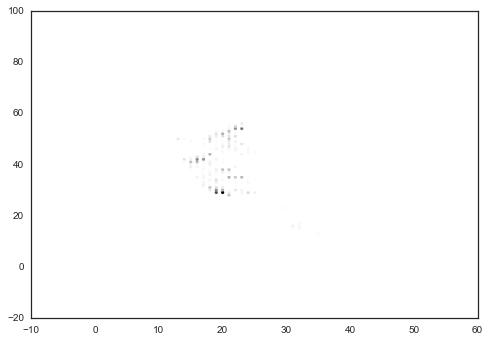

In [46]:
grid_counts = make_grid_counts(data2015)
plot_grid(grid_counts)

In [16]:
sum(grid_counts)

1280.0

The deer counts appear to be located in a particular region, and from this view do not seem to be in high number.  We will add more years to add to this dataset.

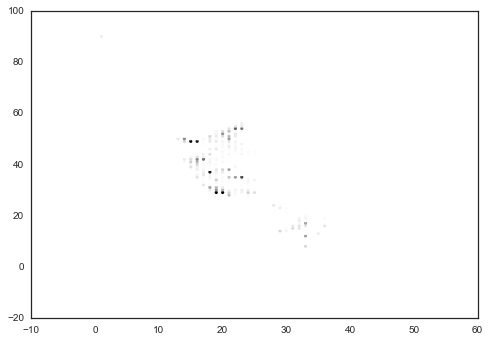

In [111]:
# look at more years
data_trial = data[data['year'] > 1992]
grid_counts = make_grid_counts(data_trial)
plot_grid(grid_counts)

In [112]:
sum(grid_counts)

5818.0

This seems to have created more counts, but mostly in the same region. As expected, inclusion of the additional years has resulted in a greater disparity between highly populated regions and less populated regions.  This may be the same researchers searching in the same regions.  Instead we will stick to the 2015 data.  

#### Playing with Grid Sizing

Instead, the problem seems to be with our grid sizing.  We will "zoom in" to this region of sightings.  Looking at the ranges of original latitudes and longitudes we see that indeed the grid size was too large for the region in which the deer appear.

In [17]:
print min(data2015.decimallatitude.values), max(data2015.decimallatitude.values)
print min(data2015.decimallongitude.values), max(data2015.decimallongitude.values)

0.0 70.71133
-164.08596 0.0


In [18]:
print min(data_trial.decimallatitude.values), max(data_trial.decimallatitude.values)
print min(data_trial.decimallongitude.values), max(data_trial.decimallongitude.values)

0.0 70.71133
-166.27487 0.0


Using the 2015 data again, we will play with different grid shapes, adjusting the sizes and ranges to look in, based on the plot we saw previously.  The smaller search space seems to work better.

In [88]:
# try again with different grids
lats = np.arange(0, 100, 2)
longs = np.arange(-180, 0, 2)

# Generate the grid
grids = list(itertools.product(lats, longs))

num_grids = len(grids)
print "Using these lat-long settings, there are %d grid squares" % num_grids



# Generate the grid indexes
lat_ids = np.digitize(lats, lats)
long_ids = np.digitize(longs, longs)

grid_ids = list(itertools.product(lat_ids, long_ids))

# returns grid_id index
def get_grid_id_from_lat_long(a_lat, a_long):
    a_lat_id = np.digitize(a_lat, lats).item(0)
    a_long_id = np.digitize(a_long, longs).item(0)
    return grid_ids.index((a_lat_id, a_long_id))


def make_grid_counts(data):
    # create store for grid id indexes
    grid_counts = np.zeros(len(grid_ids))

    # Build grid counts
    for i in range(0, len(data)):
        # get grid id index
        idx = get_grid_id_from_lat_long(data.iloc[i,0],data.iloc[i,1])

        # add to grid_counts
        grid_counts[idx] += 1
    
    return grid_counts

def plot_grid(grid_counts):
    pos = np.array(grid_ids)
    colors = grid_counts / np.double(np.max(grid_counts))
    plt.scatter(pos[:,0], pos[:,1], s=20, c=colors, cmap='gray_r', edgecolors='none')
    plt.show()

Using these lat-long settings, there are 4500 grid squares


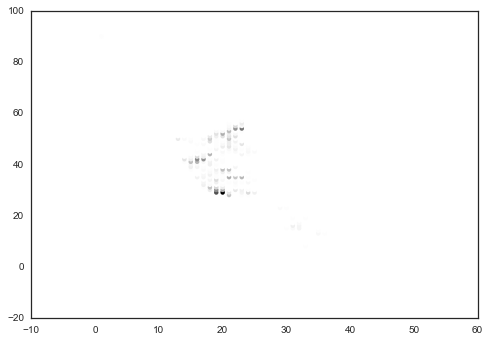

In [89]:
grid_counts = make_grid_counts(data2015)
plot_grid(grid_counts)

The results look good, though we can still take a closer look.

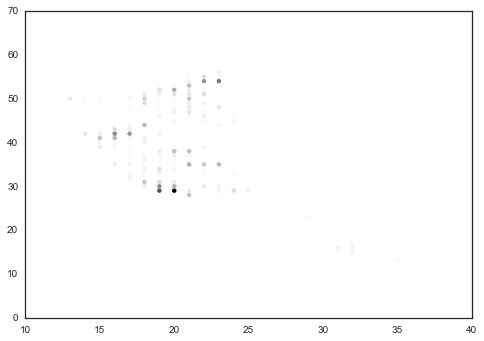

In [115]:
# settings zoomed in for 2015 data
def plot_grid(grid_counts):
    pos = np.array(grid_ids)
    colors = grid_counts / np.double(np.max(grid_counts))
    plt.scatter(pos[:,0], pos[:,1], s=20, c=colors, cmap='gray_r', edgecolors='none')
    plt.xlim(10,40)
    plt.ylim(0,70)
    plt.show()

grid_counts = make_grid_counts(data2015)
plot_grid(grid_counts)

Focus on this area:  


x: [10, 40]  
y: [0, 70]  


Looking at this region we can see that the distribution in number of deer can be related to number of deer in close proximity.  In other words, having a large number of deer in one area signifies a large number of deer in its surrounding regions.  


## Start Modeling

We model the deer sightings with a Poisson distribution, since each locational sighting occurs as independent events in a given time. These points are indicators for deer population in a certain region.  Points are correlated in such a way that a relationship between points decays exponentially with greater distances.

$C \sim Pois(w^2 \lambda)$ where $\lambda = Exp[a + Z]$  

$a \sim N(0,1)$  

$Z \sim MVN(0,\Sigma)$ where $\Sigma = Exp[||X_i-X_j||^2 / \phi]$


Our log likelihood becomes:

$log(C|\lambda) = logpmf(Pois(w^2 \cdot Exp[a + Z_i]))$

References: We use the elliptical slice sampler as given in HW4 and refer to the solution code as well.

In [113]:
#elliptical slice sampler (Murray, Adams, and MacKay JMLR 2010)
# Inputs:
# Y: observed data
# Sig: covariance matrix of the prior
# log_lik: the log likelihood function
# N_mcmc: number of desired samples
# burn_in: number of burn in iterations
# N: dimensionality of the input, this should be M+1 because alpha is part of Sigma

# returns an array of samples of size N_mcmc x N

    
def ess(Y, Sig,log_lik, N_mcmc, burn_in, N):
    print 'running elliptical slice sampling...'
    mcmc_samples = np.zeros((N_mcmc+burn_in, N))
    norm_samples = np.random.multivariate_normal(np.zeros(N), Sig, N_mcmc+burn_in)
    unif_samples = np.random.uniform(0,1,N_mcmc+burn_in)
    theta = np.random.uniform(0,2*np.pi,N_mcmc+burn_in)
    theta_min = theta-2*np.pi
    theta_max = theta+2*np.pi
    for i in range(1,N_mcmc+burn_in):
        
        if i%100 == 0:
            print i
        f = mcmc_samples[i-1,:]
        #print f, Y
        llh_thresh = log_lik(f,Y) + np.log(unif_samples[i])
        f_star = f*np.cos(theta[i])+norm_samples[i,:]*np.sin(theta[i])
        while log_lik(f_star,Y) < llh_thresh:
            if theta[i] < 0:
                theta_min[i] = theta[i]
            else:
                theta_max[i] = theta[i]
            theta[i] = np.random.uniform(theta_min[i],theta_max[i],1)  
            f_star = f*np.cos(theta[i])+norm_samples[i,:]*np.sin(theta[i]) 		
        mcmc_samples[i,:] = f_star
    return mcmc_samples[(burn_in+1):(burn_in+N_mcmc),]

In [149]:
#Calculate Sigma
def get_sig(phi):
    X = np.array(grid_ids)
    M = grid_counts.size
    
    sigma = np.zeros((M+1, M+1))
    sigma[0,0] = 1
    off = 0.00001
    
    # fill augmented sigma
    for i in range (M):
        for j in range (M):
            if i == j:
                sigma[i+1,j+1] = np.exp(-((X[i:i+1,0] - X[j:j+1,0])**2 + (X[i:i+1,1] - X[j:j+1,1])**2) / phi) + off
            else:
                sigma[i+1,j+1] = np.exp(-((X[i:i+1,0] - X[j:j+1,0])**2 + (X[i:i+1,1] - X[j:j+1,1])**2) / phi)
    
    return sigma


In [150]:
# log likelihood for poisson
def log_lik (f, Y):
    M = grid_counts.size
    w = 1
    
    result = 0
    for i in range(M):
        result = result + scipy.stats.poisson.logpmf(Y[i],w**2 * np.exp(f[0] + f[i+1]))
    return result

In [168]:
sigma = get_sig(0.00001)
results = ess(grid_counts, sigma,log_lik, 1000, 500, M+1)

running elliptical slice sampling...
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


In [159]:
# plot comparison
# uses grid_ids here for axes
def plot_compare(counts, counts2):
    # use grid_ids as axes
    X = np.array(grid_ids)
    
    plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
    
    # left plot - original
    plt.subplot(121)
    colors = counts / np.double(np.max(counts))
    plt.scatter(X[:,0], X[:,1], s=10, c=colors, cmap='gray_r', edgecolors='none')
    plt.xlim(10,40)
    plt.ylim(0,70)
    plt.title("Original Data Intensity Map")
    
    # right plot - posterior mean/result
    plt.subplot(122)    
    colors2 = counts2 / np.double(np.max(counts2))
    plt.scatter(X[:,0], X[:,1], s=10, c=colors2, marker = 'o', edgecolors='none')
    plt.xlim(10,40)
    plt.ylim(0,70)
    plt.title("Posterior Mean Intensity Map")
    plt.show()

In [160]:
def lambdas(x): 
    lambdas = []
    for i in range(M):
        lambdas.append(np.exp(x[0] + x[i+1])) 
    
    return lambdas

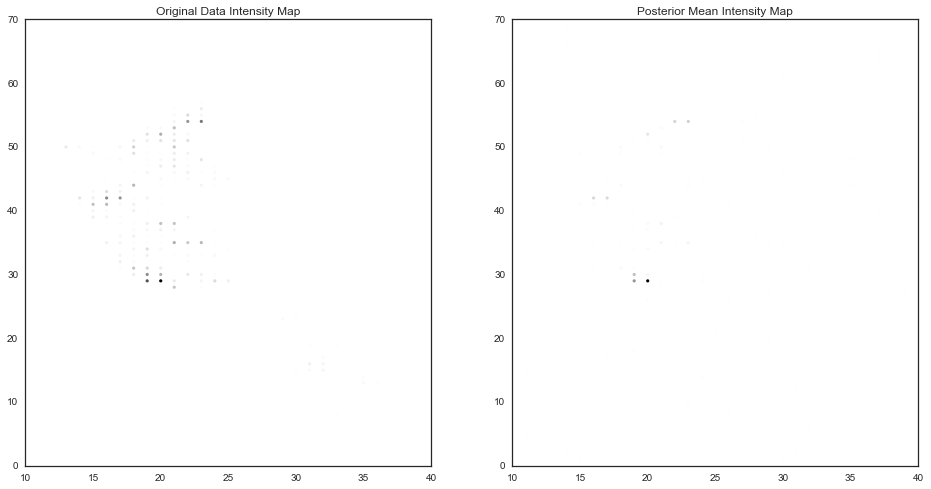

In [172]:
final_results = results.mean(axis=0)
plot_compare(grid_counts, lambdas(final_results))

The MAP value is: -2.02376470754


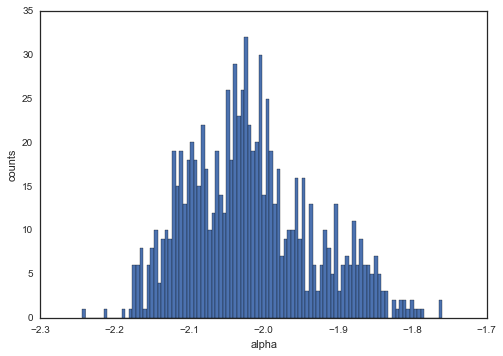

In [173]:
# plot histogram to see if params converged to a particular value
# checking alpha
p_hist = plt.hist(results[100:,0], bins=100)
xx= np.linspace(-3,7,101)
plt.xlabel("alpha")
plt.ylabel("counts")
p_map_index = np.argmax(p_hist[0])
p_hist_bin_middle = 0.5*p_hist[1][:-1] + 0.5*p_hist[1][1:]
p_map = p_hist_bin_middle[p_map_index]
print "The MAP value is:",p_map

This seems to have converged on a value, but the intensity plot shows points not having much influence on each other. The phi value is too small.

#### Changing phi

We tried various values of phi to change the degree of influence each point had on eachother. Not all are shown, to save space.

In [177]:
# plot comparison
# uses grid_ids here for axes
# updating function to be able to use longitude/latitude and put on correct axis as well
def plot_compare(counts, counts2, longlat=False):
    # use grid_ids as axes
    X = np.array(grid_ids)
    plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
    
    # to plot with actual longitude/latitude coordinates
    if longlat == True:
        X = np.array(grids)
        plt.figure(num=None, figsize=(20, 8), dpi=80, facecolor='w', edgecolor='k')
    
    # left plot - original
    plt.subplot(121)
    colors = counts / np.double(np.max(counts))
    if longlat == False:
        plt.scatter(X[:,0], X[:,1], s=40, c=colors, cmap='gray_r', edgecolors='none')
        plt.xlim(10,40)
        plt.ylim(0,70)
    else:
        plt.scatter(X[:,1], X[:,0], s=40, c=colors, cmap='gray_r', edgecolors='none')
        plt.ylim(20,60)
        plt.xlim(-150,-50)
        plt.ylabel('latitude')
        plt.xlabel('longitude')
        plt.title("Original Data Intensity Map")
    
    # right plot - posterior mean/result
    plt.subplot(122)    
    colors2 = counts2 / np.double(np.max(counts2))
    if longlat == False:
        plt.scatter(X[:,0], X[:,1], s=40, c=colors, cmap='gray_r', edgecolors='none')
        plt.xlim(10,40)
        plt.ylim(0,70)
    else:
        plt.scatter(X[:,1], X[:,0], s=40, c=colors, cmap='gray_r', edgecolors='none')
        plt.ylim(20,60)
        plt.xlim(-150,-50)
        plt.ylabel('latitude')
        plt.xlabel('longitude')
        plt.title("Posterior Mean Intensity Map")
    
    plt.show()

In [58]:
sigma = get_sig(0.5)
sum(sigma)

array([ 1.        ,  1.28975808,  1.4434544 , ...,  1.44383538,
        1.4434544 ,  1.28975808])

In [59]:
results = ess(grid_counts, sigma,log_lik, 1000, 500, M+1)

running elliptical slice sampling...
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


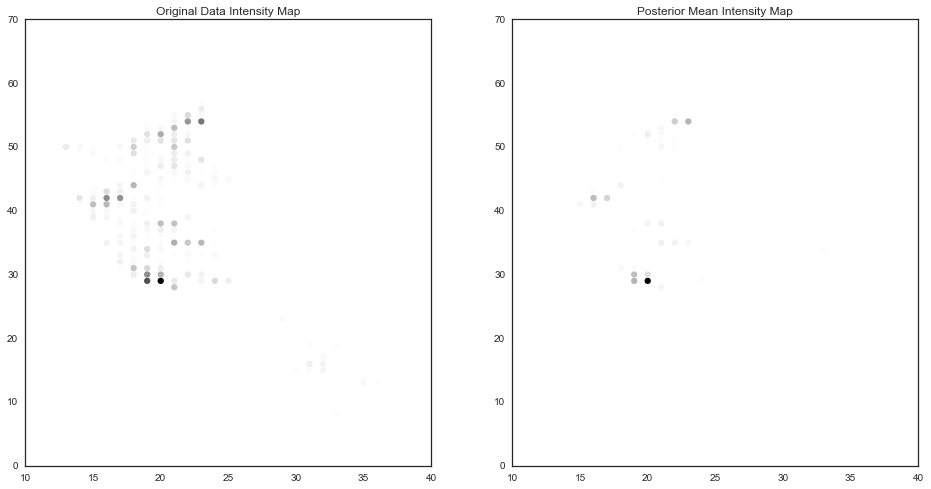

In [60]:
final_results3 = results.mean(axis=0)
plot_compare(grid_counts, lambdas(final_results3))

### USE THIS

In [63]:
sigma = get_sig(10)
sum(sigma)

array([  1.        ,   7.2847061 ,   8.9674544 , ...,  10.41339933,
         8.9674544 ,   7.2847061 ])

In [95]:
results = ess(grid_counts, sigma,log_lik, 1000, 500, M+1)

running elliptical slice sampling...
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


/Users/crystal_lim/Desktop/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: covariance is not positive-semidefinite.


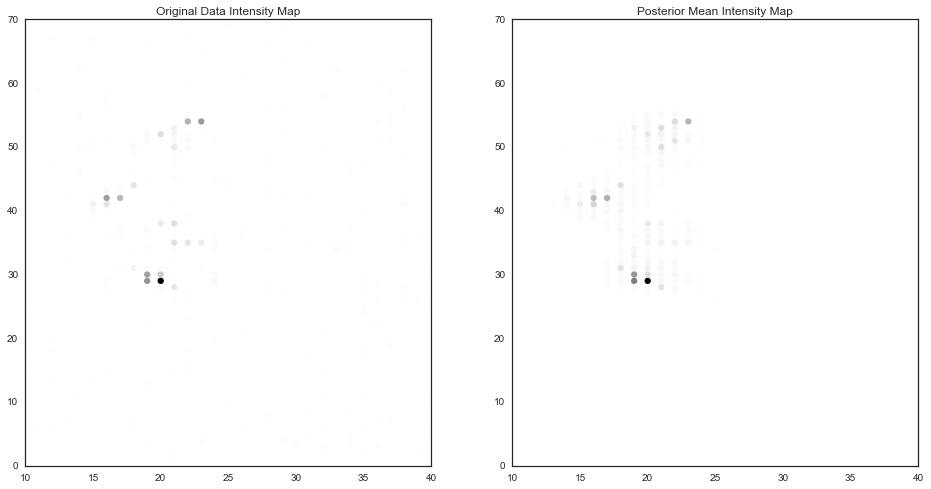

In [68]:
final_results4 = results.mean(axis=0)
plot_compare(grid_counts, lambdas(final_results4))

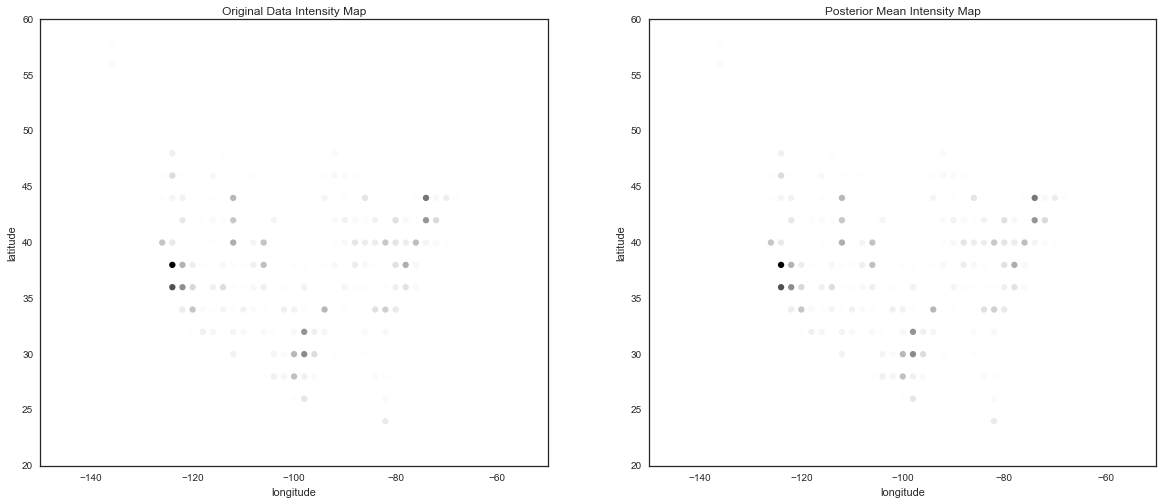

In [176]:
plot_compare(grid_counts,lambdas(final_results4),True)

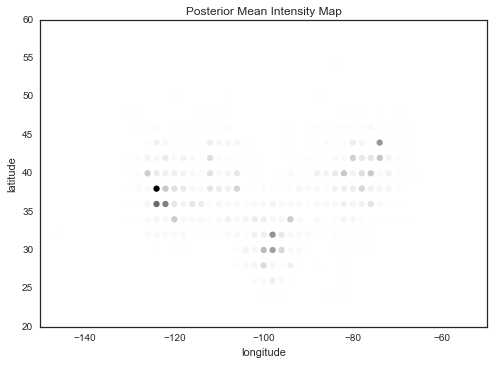

In [75]:
# graphing results by itself
counts = np.array(lambdas(final_results4))

pos = np.array(grids)

colors = counts / np.double(np.max(counts))
plt.scatter(pos[:,1], pos[:,0], s=40, c=colors, cmap='gray_r', edgecolors='none')

plt.ylim(20,60)
plt.xlim(-150,-50)

plt.ylabel('latitude')
plt.xlabel('longitude')

plt.title("Posterior Mean Intensity Map")
plt.show()

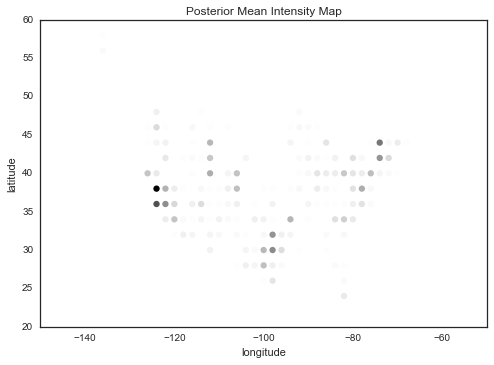

In [179]:
# plotting original alone
counts = np.array(grid_counts)

pos = np.array(grids)

colors = counts / np.double(np.max(counts))
plt.scatter(pos[:,1], pos[:,0], s=40, c=colors, cmap='gray_r', edgecolors='none')

plt.ylim(20,60)
plt.xlim(-150,-50)

plt.ylabel('latitude')
plt.xlabel('longitude')

plt.title("Posterior Mean Intensity Map")
plt.show()

The posterior mean intensity map looks like it has slightly improved uppon the original binned intensity map. You can see it is smoother in regards to location and the spread of intensity to surrounding areas.  This makes sense as you are likely to find deer in surrounding areas of highly populated regions. 

The MAP value is: -3.48236811767


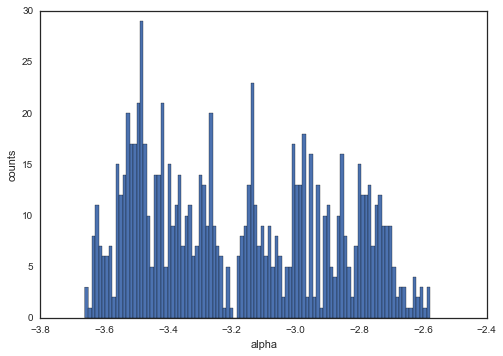

In [102]:
# did it converge
p_hist = plt.hist(results[100:,0], bins=100)
xx= np.linspace(-3,7,101)
plt.xlabel("alpha")
plt.ylabel("counts")
p_map_index = np.argmax(p_hist[0])
p_hist_bin_middle = 0.5*p_hist[1][:-1] + 0.5*p_hist[1][1:]
p_map = p_hist_bin_middle[p_map_index]
print "The MAP value is:",p_map

Unfortunately it appears like alpha has not converged at this point, though the graph does look like it improved on the original data. The parameter values converged for smaller values of phi, though those intensity plots were not as useful since this lowered the correlation between distant points, leaving much of the map empty with hotspots pinpointed only at very highly populated areas.  Unfortunately, when using a phi large enough to create a reasonable intensity map, our parameter values had not yet converged.  These are of course tradeoffs, and may have to do with the quality of our data as well.

### DRAW ON A MAP

In order to make this data more applicable to real life we wanted to show the data on the actual map. To do this we used Matplotlib's Basemap toolkit.  You can find more about it here: http://matplotlib.org/basemap/index.html

In [26]:
from mpl_toolkits.basemap import Basemap, cm

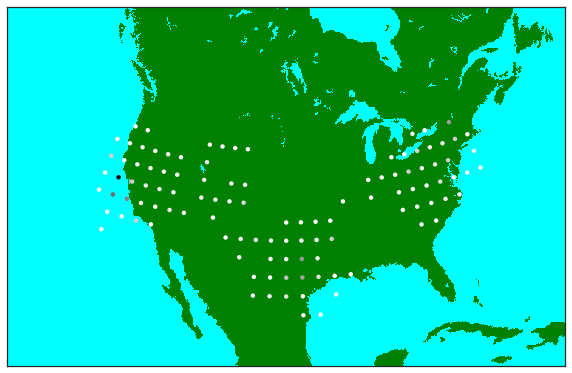

In [100]:
X = np.array(grids)
counts = np.array(lambdas(final_results4))

# PLOT ON WORLD MAP
fig1 = plt.figure(figsize=(10,10))

# setup Lambert Conformal basemap.
# set resolution=None to skip processing of boundary datasets.

m = Basemap(width=7000000,height=4500000,projection='lcc',
            resolution=None,lat_1=45.,lat_2=55,lat_0=40,lon_0=-100.)

#m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,\
#            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

# set a threshold so you only see values with higher prob
P = []
c = []
for i in range(len(X)):
    if counts[i] > 1.9:
        P.append(X[i])
        c.append(counts[i])

P = np.array(P)
c = np.array(c)
        
x,y = m(P[:,1],P[:,0])

colors = c / np.double(np.max(c))
m.scatter(x, y, s=20, c=colors, cmap='gray_r', edgecolors='none')



# draw a land-sea mask for a map background.
# lakes=True means plot inland lakes with ocean color.
m.drawlsmask(land_color='green',ocean_color='aqua',lakes=True)
plt.show()

We now compare it to our original data

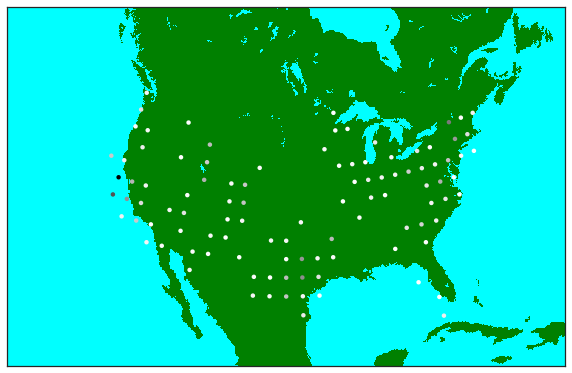

In [30]:
X = np.array(grids)
counts = grid_counts

# PLOT ON WORLD MAP
fig1 = plt.figure(figsize=(10,10))

# setup Lambert Conformal basemap.
# set resolution=None to skip processing of boundary datasets.

m = Basemap(width=7000000,height=4500000,projection='lcc',
            resolution=None,lat_1=45.,lat_2=55,lat_0=40,lon_0=-100.)

#m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,\
#            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')


#x,y = m(longs,lats)
#m.scatter(x,y,marker='o',color='k',s=10) 

# set a threshold so you only see values with higher prob
P = []
c = []
for i in range(len(X)):
    if counts[i] > 1.9:
        P.append(X[i])
        c.append(counts[i])

P = np.array(P)
c = np.array(c)
        
x,y = m(P[:,1],P[:,0])

colors = c / np.double(np.max(c))
m.scatter(x, y, s=20, c=colors, cmap='gray_r', edgecolors='none')



# draw a land-sea mask for a map background.
# lakes=True means plot inland lakes with ocean color.
m.drawlsmask(land_color='green',ocean_color='aqua',lakes=True)
plt.show()

### Compare to Density Plot

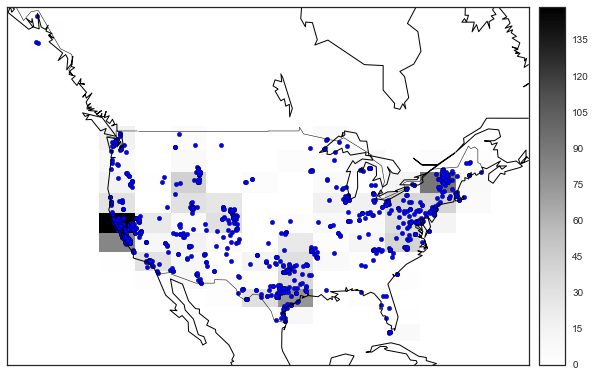

In [54]:
fig1 = plt.figure(figsize=(10,10))

m = Basemap(projection='merc',llcrnrlat=20,urcrnrlat=60,\
            llcrnrlon=-140,urcrnrlon=-60,lat_ts=20,resolution='c')

nx, ny = 30, 30

lats = data2015.decimallatitude.values
lons = data2015.decimallongitude.values

# create bins
lon_bins = np.linspace(lons.min(), lons.max(), nx+1)
lat_bins = np.linspace(lats.min(), lats.max(), ny+1)

# histogram to get frequencies in each bin
density, _, _ = np.histogram2d(lats, lons, [lat_bins, lon_bins])

#density = np.where(density == 0, 20, density)

# Turn the lon/lat bins into 2 dimensional arrays ready 
# for conversion into projected coordinates
lon_bins_2d, lat_bins_2d = np.meshgrid(lon_bins, lat_bins)

# convert the xs and ys to map coordinates
xs, ys = m(lon_bins_2d, lat_bins_2d)

cmesh = m.pcolormesh(xs,ys,density)
m.colorbar(cmesh)

m.drawcoastlines()
m.drawcountries()


# overlay the scatter points to see that the density 
# is working as expected
m.scatter(*m(lons, lats))


plt.show()

We can also compare this to a simple density plot. It seems as though it matches the trend of our intensity plot which supports the validity of our model.  We can also have the original data (not binned) overlaid here and we can see just how it corresponds to our Hierarchical Bayesian Model.


#### Testing ess one more time with an even larger phi

In [82]:
sigma = get_sig(100)
results = ess(grid_counts, sigma,log_lik, 1000, 500, M+1)

running elliptical slice sampling...
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


/Users/crystal_lim/Desktop/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: covariance is not positive-semidefinite.


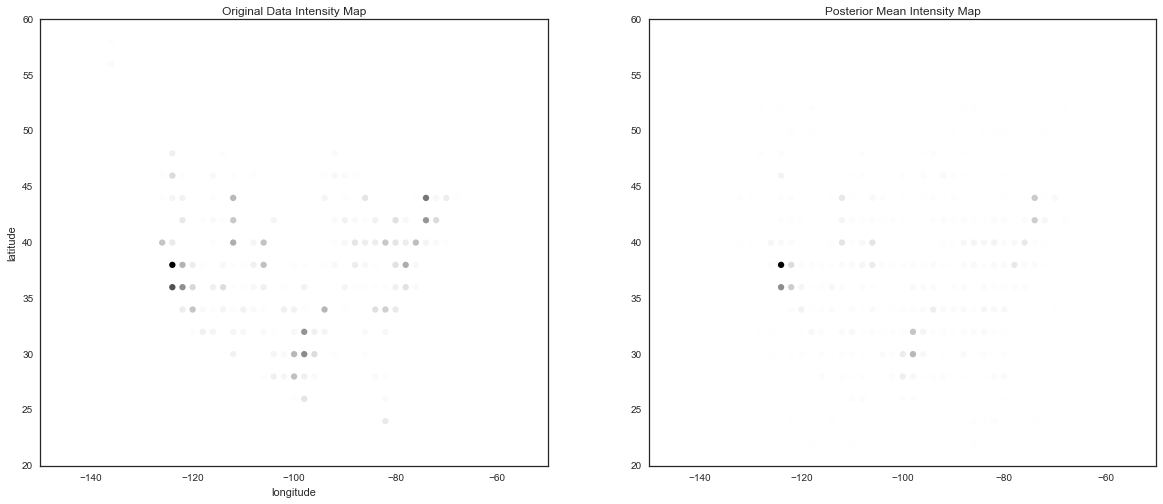

In [84]:
grid_counts = make_grid_counts(data2015)
X = np.array(grids)

final_results5 = results.mean(axis=0)

plot_compare(grid_counts, lambdas(final_results5),True)

The MAP value is: -3.86433418312


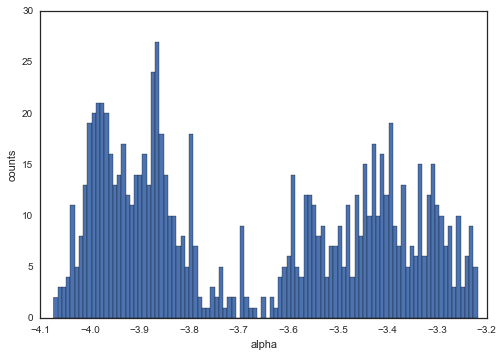

In [86]:
# did it converge
p_hist = plt.hist(results[100:,0], bins=100)
xx= np.linspace(-3,7,101)
plt.xlabel("alpha")
plt.ylabel("counts")
p_map_index = np.argmax(p_hist[0])
p_hist_bin_middle = 0.5*p_hist[1][:-1] + 0.5*p_hist[1][1:]
p_map = p_hist_bin_middle[p_map_index]
print "The MAP value is:",p_map

We try the eliptical slice sampler one more time to check, this time going even higher than 10. Alpha seems to be gravitating towards two different solutions.  We settle down with phi = 10 as our best solution.

### Try with pymc now

To try another method, we use the pymc implementation for a Poisson distribution to see if it is worth pursuing.

In [35]:
zeroes = np.zeros(M)

precision_matrix = np.linalg.inv(sigma)

z = pm.MvNormal( "z", zeroes, precision_matrix[1:, 1:] )
a = pm.Normal("a", 0, 1)
w = 1

#our theta 
@pm.deterministic
def mu(w = w, z=z, a = a):
    temp = np.exp(a+z)
    result = w**2 *temp
    return result

likelihood = pm.Poisson('likelihood', mu=mu, value = grid_counts, observed=True )
response_model=pm.Model([a, z, likelihood])
mcmc = pm.MCMC(response_model)
mcmc.sample(iter=10000, burn=1000, thin = 2)

 [-----------------100%-----------------] 10001 of 10000 complete in 9652.7 sec

The MAP value is: -1.67199825701


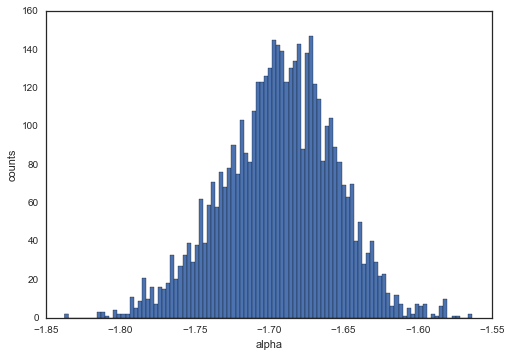

In [36]:
p_hist = plt.hist(a.trace(), bins=100)
xx= np.linspace(-3,7,101)
plt.xlabel("alpha")
plt.ylabel("counts")
p_map_index = np.argmax(p_hist[0])
p_hist_bin_middle = 0.5*p_hist[1][:-1] + 0.5*p_hist[1][1:]
p_map = p_hist_bin_middle[p_map_index]
print "The MAP value is:",p_map

In [37]:
pymc_z= mcmc.stats()['z']['mean']
pymc_a = mcmc.stats()['a']['mean']
print pymc_z
print pymc_a

[ 0.79918809  1.54091845  1.12863688 ...,  0.35132024  1.3097907
  0.06981726]
-1.6932224706


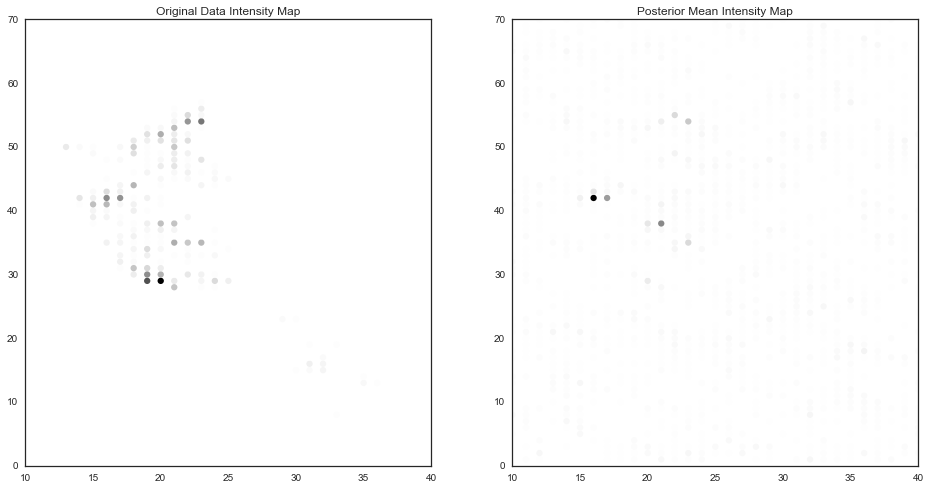

In [50]:
non_conjugate_lambdas_pymc = []
for x in range(M):
    non_conjugate_lambdas_pymc.append(np.exp(pymc_a + pymc_z[x])) 

plot_compare(grid_counts, non_conjugate_lambdas_pymc)

This method took way too long, 2.68 hrs for 10000 iterations, and did not develop enough correlation between neighboring points yet but it could be on the right track. Alpha was converging and more frequent spots getting darker.  Unfortunately, it is not practical to do many tests with this in a reasonable amount of time.

## Final Thoughts

Overall the Hierarchical Bayes model in combination with an eliptical slice sampling method could be useful if data collection is improved and if more data was collected. We initially made the assumption that the data followed a Poisson distribution.  However, the data points are not as indepently occurring as they should be since the data is biased based on which scientists are studying this particular species. The data appears to reflects more of where these scientists decided to collect data, but we now know the method is usable and could be used in the future if this database is more widely used and data actually reflected true species population location. For example, if there were equidistant watch stations on the lookout for certain animals around the country, we would have more accurate data to work with.  

Given additional time and reliable data we would have also liked to optimize for phi, study additional species, as well as create intensity maps to locate regions with greater biodiversity.